# NBA Success Model Training & Analysis

This notebook trains and analyzes two regression models (Linear Regression and Decision Tree) using the features examined in EDA. It includes model evaluation, SHAP value analysis, and decision tree visualization.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# Load and Filter Data
data = pd.read_csv("nba_success_dataset_2010-2019.csv")
data = data[(data["Highest_WS"] >= data["Highest_WS"].quantile(0.02)) & (data["Highest_WS"] <= data["Highest_WS"].quantile(0.98))]
print(f"Data shape after filtering: {data.shape}")
data.head()

Data shape after filtering: (336, 77)


,Unnamed: 0,PLAYER,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,...,TEAM,AFFILIATION,YEAR,ROUND,ROUND.1,OVERALL,allstar_apps,Highest_WS,Highest_BPM,Overall PIE
1,1,Zion Williamson,Duke,ACC,33,64.9,129.2,28.2,70.8,70.19,...,New Orleans Pelicans,Duke,2019.0,1,1,1,0.0,8.7,5.8,12.7163
2,2,Victor Oladipo,Indiana,B10,36,70.4,122.7,22.6,64.8,67.12,...,Orlando Magic,Indiana,2013.0,1,2,2,2.0,8.2,5.8,7.6930
4,4,Denzel Valentine,Michigan St.,B10,31,72.5,125.5,28.9,57.9,60.82,...,Chicago Bulls,Michigan State,2016.0,1,14,14,0.0,2.5,-0.6,2.8370
5,5,Frank Kaminsky,Wisconsin,B10,39,81.4,126.2,28.1,59.0,62.78,...,Charlotte Hornets,Wisconsin,2015.0,1,9,9,0.0,3.6,4.9,5.5937
6,6,Willie Cauley-Stein,Kentucky,SEC,37,54.5,118.9,14.9,59.6,57.95,...,Sacramento Kings,Kentucky,2015.0,1,6,6,0.0,6.7,1.2,4.9028


In [3]:
# Calculate new predictors using ratio-focused formulas
# Efficient usage
if all(col in data.columns for col in ['usg', 'TS_per']):
    data['Efficient usage'] = data['usg'] * data['TS_per'] / 100
else:
    data['Efficient usage'] = np.nan

# Points per minute
if all(col in data.columns for col in ['pts', 'Min_per']):
    data['points per minute'] = data['pts'] / (data['Min_per'] + 0.1)
else:
    data['points per minute'] = np.nan

# Impact per usage
if all(col in data.columns for col in ['bpm', 'usg']):
    data['impact per usage'] = data['bpm'] / (data['usg'] + 0.1)
else:
    data['impact per usage'] = np.nan

# Two way impact
if all(col in data.columns for col in ['obpm', 'dbpm']):
    data['two way impact'] = data['obpm'] + data['dbpm']
else:
    data['two way impact'] = np.nan

# Versatility score
if all(col in data.columns for col in ['AST_per', 'ORB_per', 'blk_per']):
    data['versatility score'] = data['AST_per'] + data['ORB_per'] + data['blk_per']
else:
    data['versatility score'] = np.nan

data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)
data.head()

,Unnamed: 0,PLAYER,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,...,OVERALL,allstar_apps,Highest_WS,Highest_BPM,Overall PIE,Efficient usage,points per minute,impact per usage,two way impact,versatility score
1,1,Zion Williamson,Duke,ACC,33,64.9,129.2,28.2,70.8,70.19,...,1,0.0,8.7,5.8,12.7163,19.79358,0.347786,0.581714,16.46254,33.6
2,2,Victor Oladipo,Indiana,B10,36,70.4,122.7,22.6,64.8,67.12,...,2,2.0,8.2,5.8,7.6930,15.16912,0.193460,0.673004,15.27724,29.7
4,4,Denzel Valentine,Michigan St.,B10,31,72.5,125.5,28.9,57.9,60.82,...,14,0.0,2.5,-0.6,2.8370,17.57698,0.264373,0.496069,14.38595,49.5
5,5,Frank Kaminsky,Wisconsin,B10,39,81.4,126.2,28.1,59.0,62.78,...,9,0.0,3.6,4.9,5.5937,17.64118,0.230297,0.487968,13.76065,28.9
6,6,Willie Cauley-Stein,Kentucky,SEC,37,54.5,118.9,14.9,59.6,57.95,...,6,0.0,6.7,1.2,4.9028,8.63455,0.124740,0.909300,13.63952,30.6


In [4]:
# Define Predictors and Target
num_predictors = ["stops", "bpm", "Rec Rank", "GP", "ftr", "Efficient usage", "points per minute", "impact per usage", "two way impact", "versatility score"]
cat_predictors = []
predictors = num_predictors + cat_predictors
target = "Highest_WS"

X = data[predictors]
y = data[target]
print("Predictors:", predictors)
print("Target:", target)

Predictors: ['stops', 'bpm', 'Rec Rank', 'GP', 'ftr', 'Efficient usage', 'points per minute', 'impact per usage', 'two way impact', 'versatility score']
Target: Highest_WS


In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression RMSE: 2.71
Linear Regression R2: 0.06


c:\Users\Franklin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


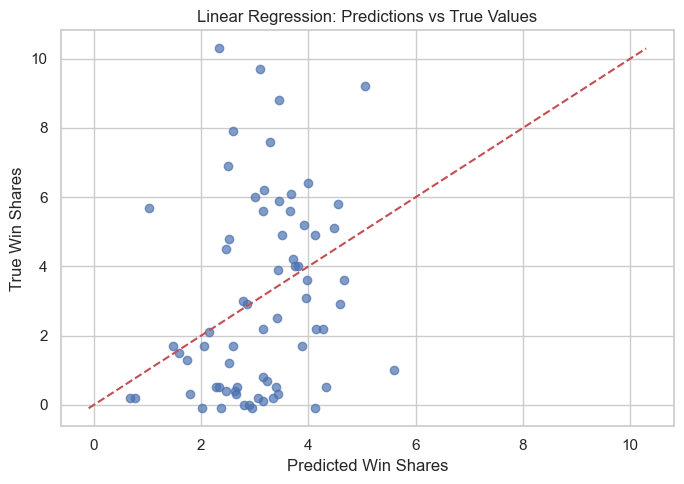

In [6]:
# Train Linear Regression model
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_lr = linreg.predict(X_test_scaled)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R2: {r2_lr:.2f}")

# Plot predictions vs true values
plt.figure(figsize=(7,5))
plt.scatter(y_pred_lr, y_test, alpha=0.7)
plt.xlabel("Predicted Win Shares")
plt.ylabel("True Win Shares")
plt.title("Linear Regression: Predictions vs True Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

Decision Tree RMSE: 3.26
Decision Tree R2: -0.37


c:\Users\Franklin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


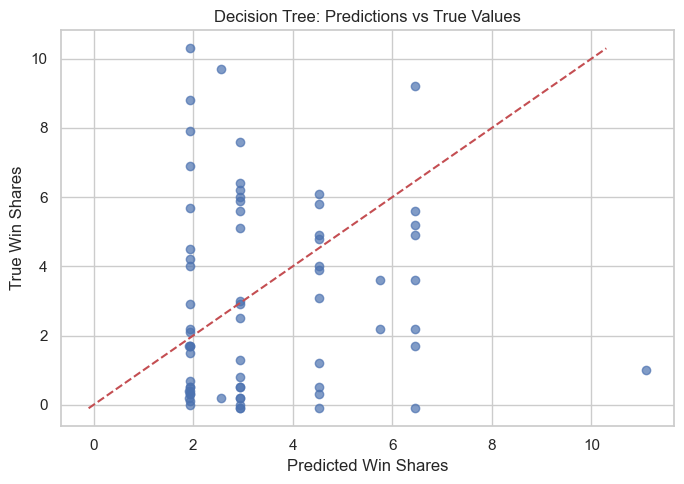

In [7]:
# Train Decision Tree model
max_depth = 3
dtree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
dtree.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = dtree.predict(X_test)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Decision Tree RMSE: {rmse_dt:.2f}")
print(f"Decision Tree R2: {r2_dt:.2f}")

# Plot predictions vs true values
plt.figure(figsize=(7,5))
plt.scatter(y_pred_dt, y_test, alpha=0.7)
plt.xlabel("Predicted Win Shares")
plt.ylabel("True Win Shares")
plt.title("Decision Tree: Predictions vs True Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

C:\Users\Franklin\AppData\Local\Temp\ipykernel_21520\3786751071.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=metrics, palette='Blues')


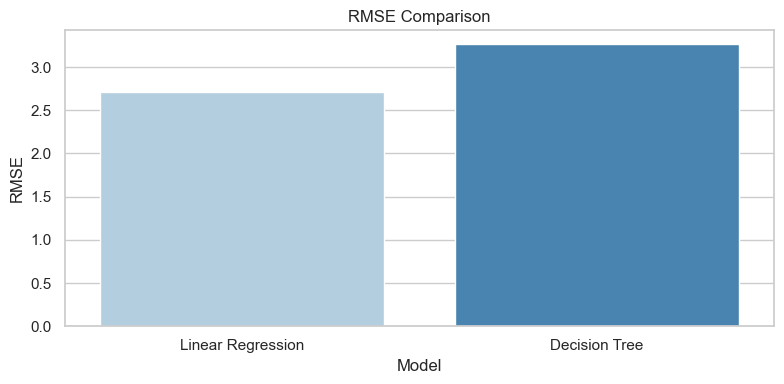

C:\Users\Franklin\AppData\Local\Temp\ipykernel_21520\3786751071.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=metrics, palette='Greens')


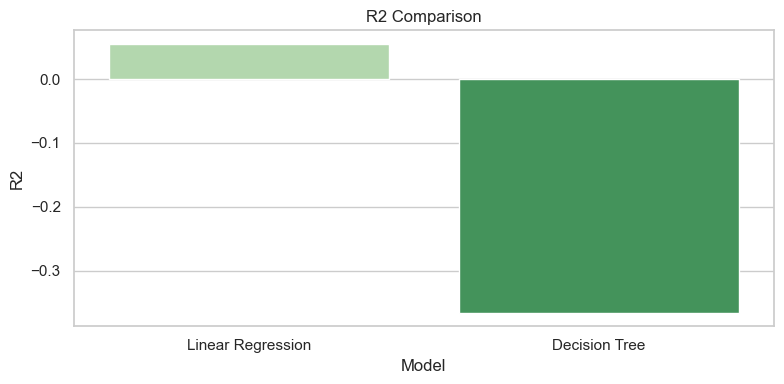

In [8]:
# Plot evaluation metrics for both models
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree'],
    'RMSE': [rmse_lr, rmse_dt],
    'R2': [r2_lr, r2_dt]
})

plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='RMSE', data=metrics, palette='Blues')
plt.title('RMSE Comparison')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='R2', data=metrics, palette='Greens')
plt.title('R2 Comparison')
plt.tight_layout()
plt.show()

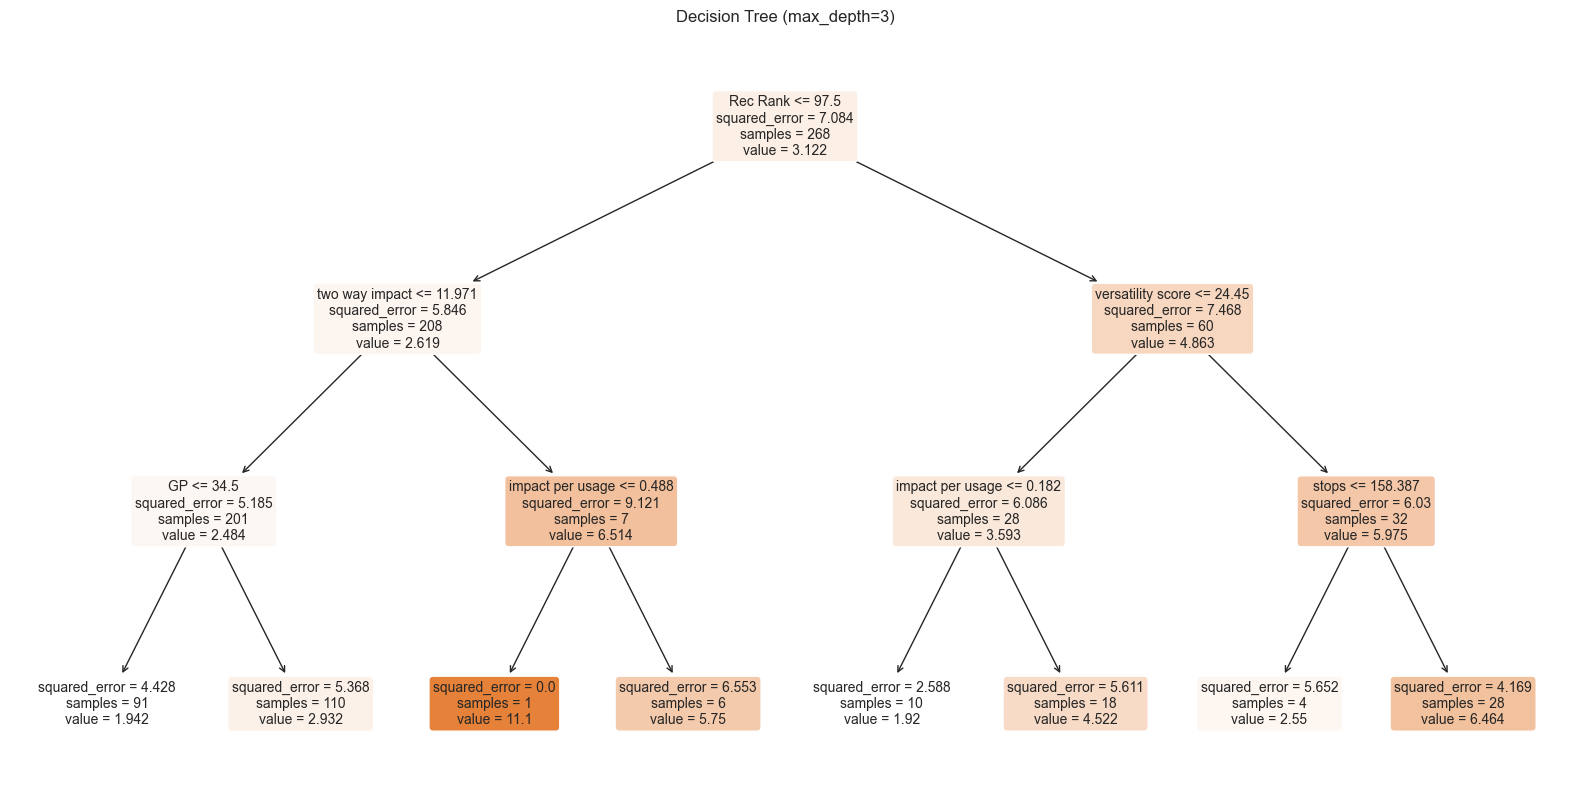

In [9]:
# Visualize the decision tree structure
plt.figure(figsize=(20, 10))
plot_tree(dtree, feature_names=predictors, filled=True, rounded=True, fontsize=10)
plt.title(f"Decision Tree (max_depth={max_depth})")
plt.show()

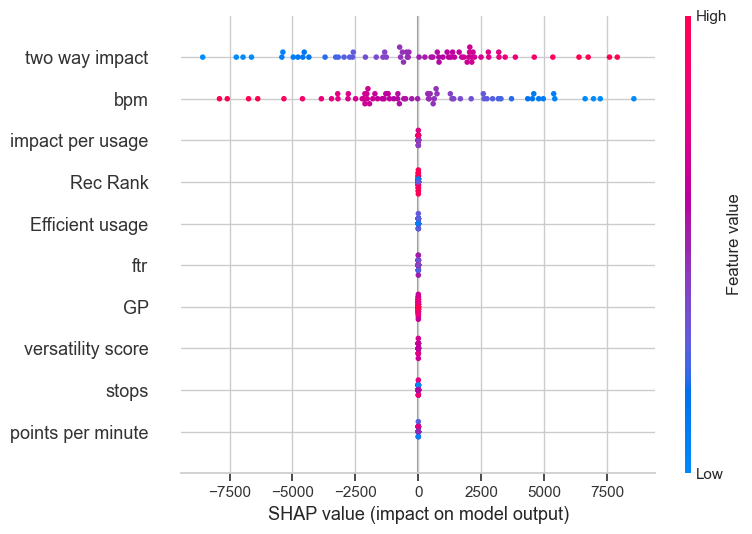

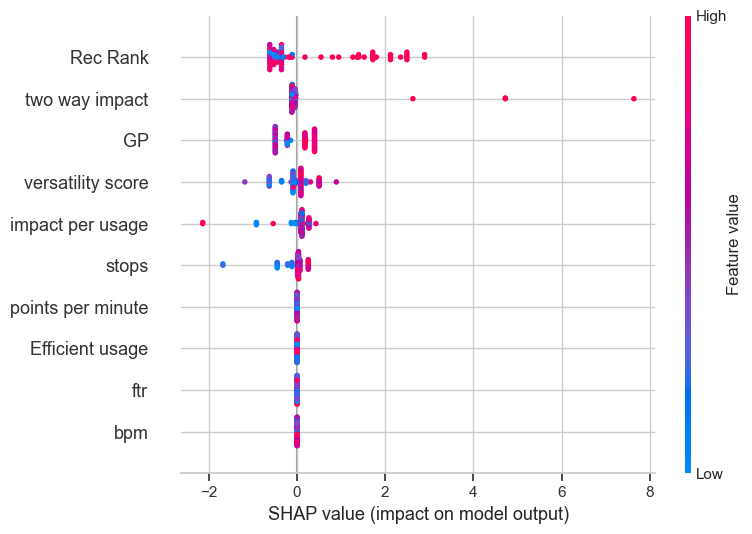

In [10]:
# SHAP analysis for Linear Regression
explainer_lr = shap.Explainer(linreg, X_train_scaled)
shap_values_lr = explainer_lr(X_test_scaled)
shap.summary_plot(shap_values_lr, X_test, feature_names=predictors)

# SHAP analysis for Decision Tree
explainer_dt = shap.Explainer(dtree, X_train)
shap_values_dt = explainer_dt(X_test)
shap.summary_plot(shap_values_dt, X_test, feature_names=predictors)

## Distribution Plots of Features with Decision Tree Thresholds

Visualize the distribution of each feature and overlay the thresholds used by the decision tree for prediction.

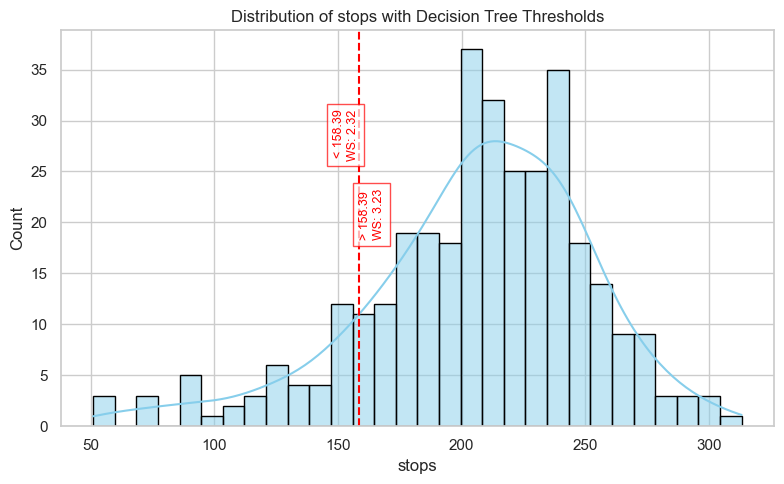

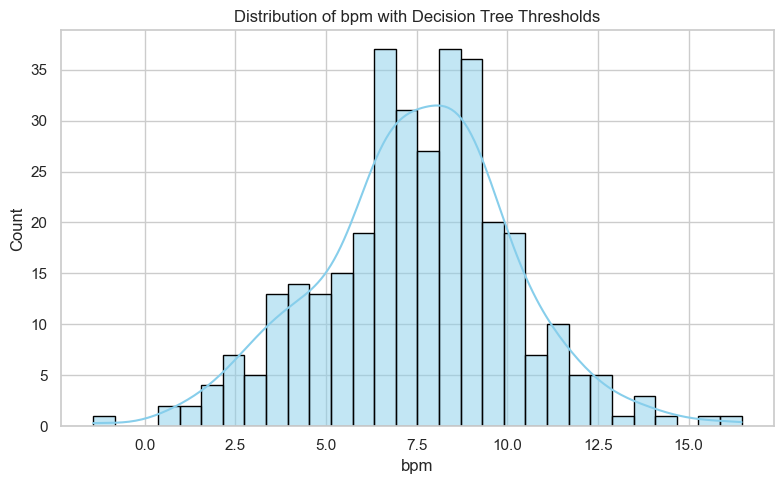

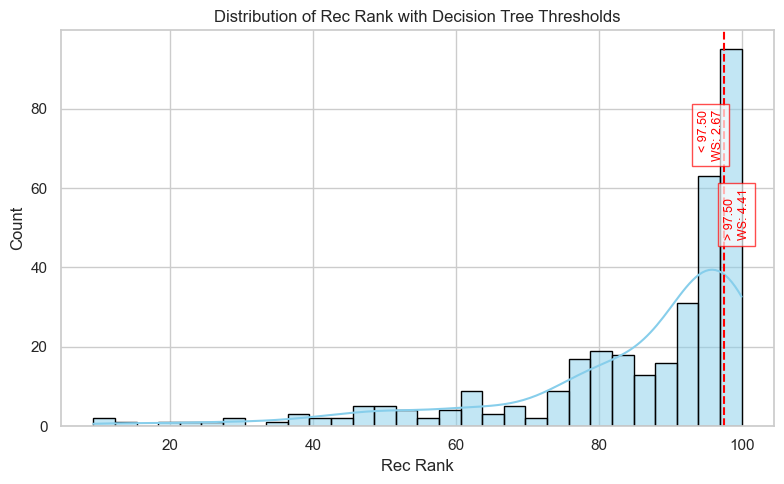

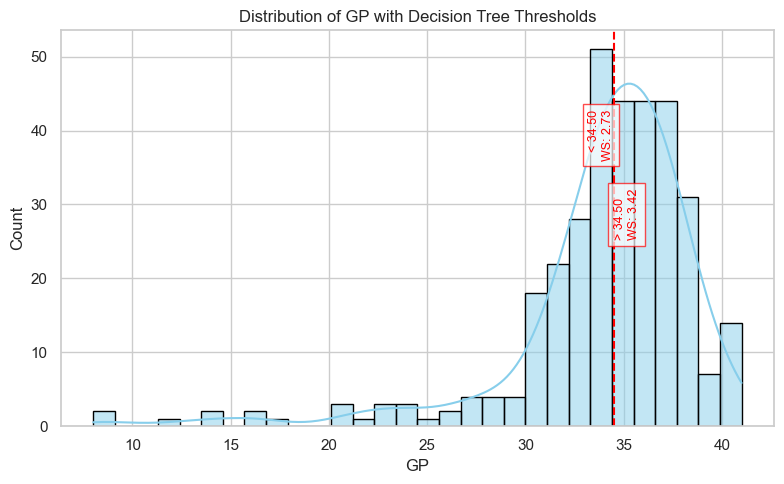

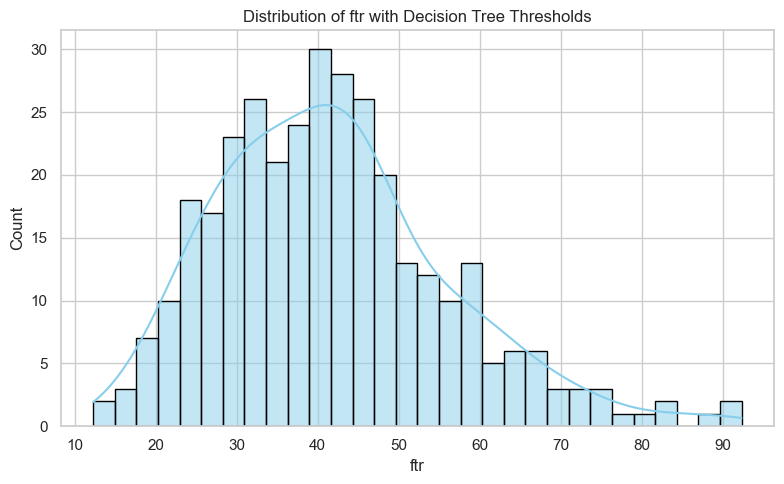

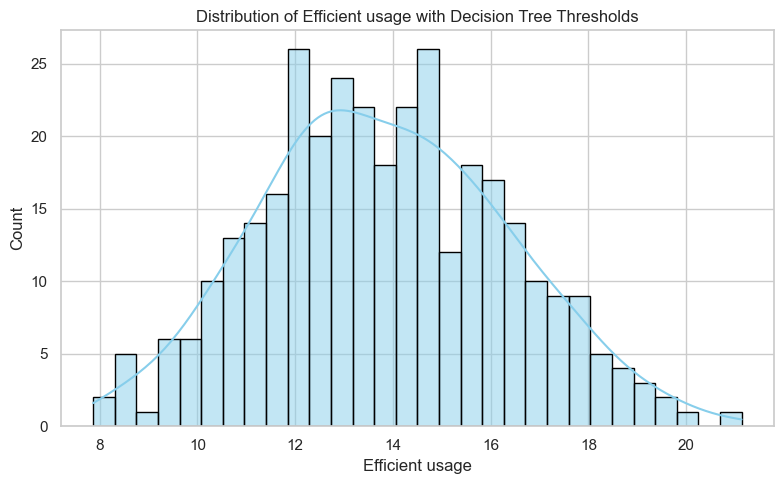

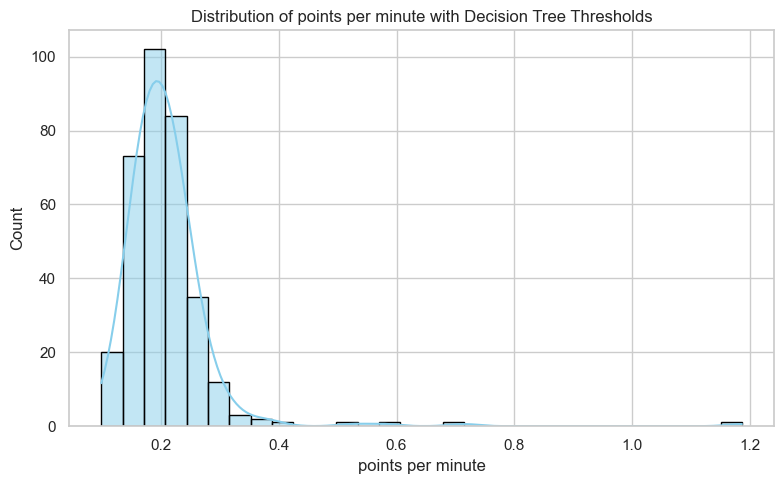

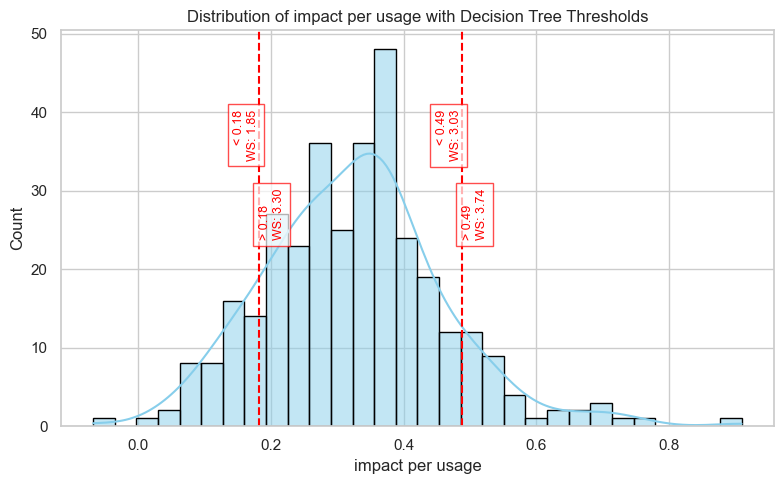

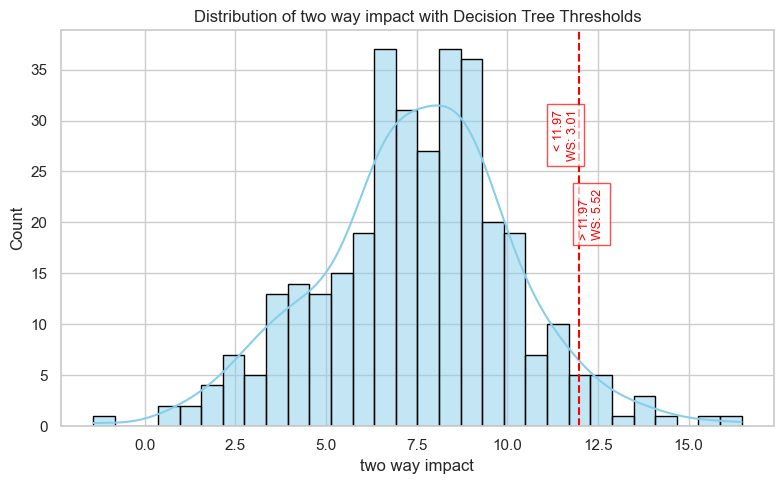

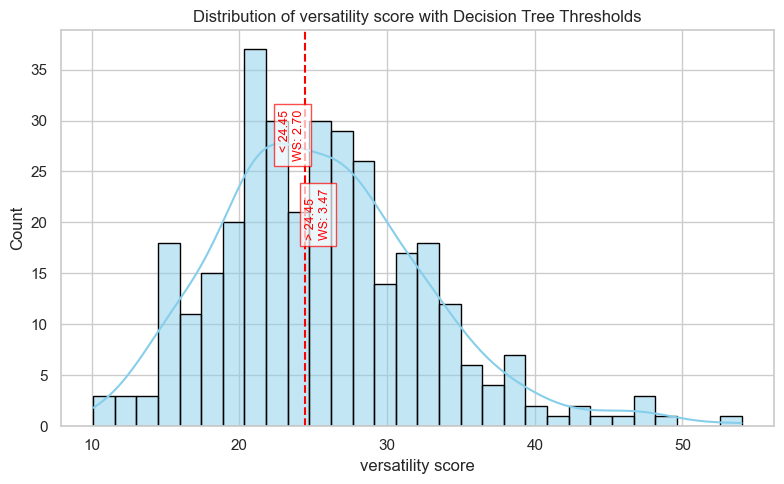

In [11]:
# Distribution plots with decision tree thresholds
import numpy as np

# Get thresholds and features from trained decision tree
dtree_fitted = dtree
thresholds = dtree_fitted.tree_.threshold
features_idx = dtree_fitted.tree_.feature
split_nodes = np.where(features_idx >= 0)[0]

for idx, predictor in enumerate(predictors):
    # Find all thresholds for this predictor
    predictor_indices = [i for i, f in enumerate(predictors) if f == predictor]
    predictor_thresholds = [thresholds[i] for i in split_nodes if features_idx[i] in predictor_indices]
    plt.figure(figsize=(8, 5))
    sns.histplot(X[predictor], kde=True, bins=30, color='skyblue', edgecolor='black')
    for t in predictor_thresholds:
        plt.axvline(t, color='red', linestyle='--')
        mean_before = y[X[predictor] <= t].mean()
        mean_after = y[X[predictor] > t].mean()
        plt.text(t, plt.ylim()[1]*0.8, f"< {t:.2f}\nWS: {mean_before:.2f}", color='red', rotation=90, va='top', ha='right', fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'))
        plt.text(t, plt.ylim()[1]*0.6, f"> {t:.2f}\nWS: {mean_after:.2f}", color='red', rotation=90, va='top', ha='left', fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'))
    plt.title(f"Distribution of {predictor} with Decision Tree Thresholds")
    plt.xlabel(predictor)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()